# Analysis and Prediction of the Matchup of Starcraft II Matches

Starcraft II is a science fiction real-time strategy video game developed and published by Blizzard Entertainment. For the last decade, it has been the premier 1v1 competitive esports title and is widely played around the globe. While it is well past its golden years, Starcraft II remains an interesting game for machine learning and deep learning research due to its strategical depth and real-time engine. For example, the DeepMind team created an AI to play Starcraft II called AlphaStar.

In this instance, the problem is not in making an AI to play Starcraft II, nor is it making a predictive model for a match outcome. The problem is to predict the racial matchup of a match given match summary statistics.

To give more context, in 1v1 competitive Starcraft II, each player can choose to play as 1 out of three races: Terran (T), Protoss (P), and Zerg (Z). Therefore, there are 6 possible matchups (including 3 mirror matchups): TvT, TvP, TvZ, PvP, PvZ, and ZvZ. What is interesting is that each matchup is usually played differently. For example, TvT is often described as a chess game, while TvZ is a game of momentum. Each race is also often regarded as having its own unique characteristics. For example, Zerg players are often considered as having higher APM (Actions per Minute) in general.

Given the background above, it is of interest to build a predictive model for the matchup. This model is not intended to actually be used to predict the matchup (since it is already apparent after all). Still, it is interesting to see whether we can analyze the different characteristics of each matchup using our predictive model. Therefore, the challenge here is not just building a good predictive model, but a good and interpretable model.

### Dataset
The dataset is sourced from the replays of professional Starcraft II matches in the last three premier tournaments (IEM Katowice 2022, DH Masters Last Chance, DH Masters Winter) and parsed through a SC2 replay parser.

To understand about the dataset, here is the data dictionary for this dataset:
1. ```game_length```: length of match in seconds.
2. ```winner```: winner of the match (1 for player 1 and 2 for player 2).
3. ```matchup```: target variable; 6 possible values.
4. ```p{i}_apm```: actions per minute for player i.
5. ```p{i}_spm```: screens per minute for player i.
6. ```p{i}_avg_pac_per_min```: average number of Perception-Action Cycle per minute for player i.
7. ```p{i}_sq```: Spending Quotient for player i.
8. ```p{i}_race```: race for player i; not available for test data.

#### Import Library and Load the Dataseta

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
# load the dataset
df = pd.read_csv('train.csv')

## Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               829 non-null    object 
 1   played_at                        829 non-null    object 
 2   tournament                       829 non-null    object 
 3   map                              829 non-null    object 
 4   game_length                      829 non-null    int64  
 5   winner                           829 non-null    int64  
 6   matchup                          829 non-null    object 
 7   p1_max_collection_rate           829 non-null    int64  
 8   p2_max_collection_rate           829 non-null    int64  
 9   p1_apm                           829 non-null    int64  
 10  p2_apm                           829 non-null    int64  
 11  p1_spm                           829 non-null    float64
 12  p2_spm                

First, let's overview the dataset. The dataset has 829 rows and 49 columns, with no null values. There are 7 categorical data, and 42 numerical data. Then, let's take a sneek peek the head of the data. Since it doesn't contain any null values, we can directly do the analysis.

In [4]:
df.head()

,id,played_at,tournament,map,game_length,winner,matchup,p1_max_collection_rate,p2_max_collection_rate,p1_apm,...,p1_avg_collection_rate_gas,p1_avg_unspent_gas,p1_gas_lost,p1_gas_collected,p2_avg_collection_rate_gas,p2_avg_unspent_gas,p2_gas_lost,p2_gas_collected,p1_race,p2_race
0,0205bd314da54b6fb363a998ca0c49ba,2022-02-25 03:01:50+00:00,IEM Katowice,2000 애트모스피어 - 래더,848,2,TvT,3778,3952,316,...,533.8,273.8,3436,6384,636.3,253.2,2864,7412,Terran,Terran
1,7ca6c874c8064364b4247780495fe4f2,2021-10-17 05:11:18+00:00,DH Masters Winter,Beckett Industries LE,612,1,PvZ,4344,3140,398,...,473.9,236.7,625,4265,427.4,201.3,850,3665,Zerg,Protoss
2,92ccfb1330424a4fb572585b8d6ea4c9,2021-10-10 01:50:23+00:00,DH Masters Winter,Beckett Industries LE,486,2,PvZ,3095,2944,389,...,226.5,157.6,800,1668,336.1,170.0,75,2436,Zerg,Protoss
3,d592c15de2a94b6aa5278b0fc241de54,2022-02-25 04:27:49+00:00,IEM Katowice,[ESL] Berlingrad,1078,2,PvZ,4064,4193,449,...,749.7,401.2,5850,11682,892.6,664.5,3850,13344,Protoss,Zerg
4,6a24b0487aef460a982d2ec930947c11,2021-12-15 19:17:24+00:00,DH Masters Last Chance,블랙번 - 래더,1001,1,PvZ,4484,4243,627,...,826.1,299.8,8975,11930,675.6,174.5,8200,10256,Zerg,Protoss


# Analysis

Let's explore the dataset, and get to know Starcraft 2 deeper. Who knows that after read this analysis, it can help you to get better decision when play the game 😃!

## The Race

What are the traits for each race? Then, which race have the best performace, which one is the worst? Who win the most?

In [5]:
# get the column name for p1 and p2
p1_only = [i for i in df.columns if i[:2] == 'p1']
p2_only = [i for i in df.columns if i[:2] == 'p2']
col_name = [i[3:] if i[:2] == 'p1' else i for i in df.columns if i[:2] != 'p2']

In [6]:
# seperate the df for p1 and p2
df_p1 = df.copy()
df_p1.drop(p2_only, axis=1, inplace=True, errors='ignore')
df_p1.columns = col_name

df_p2 = df.copy()
df_p2.drop(p1_only, axis=1, inplace=True, errors='ignore')
df_p2.columns = col_name

In [7]:
# make new df, then combine the 2 previous df
df_new = df_p1.copy()
df_new = df_new.append(df_p2)
df_new.sort_values(by='id', inplace=True)

In [8]:
df_new_group = df_new.groupby('race').mean()
df_new_group

,game_length,winner,max_collection_rate,apm,spm,workers_produced,workers_killed,workers_lost,supply_block,sq,...,avg_pac_actions,avg_pac_gap,avg_collection_rate_minerals,avg_unspent_minerals,minerals_lost,minerals_collected,avg_collection_rate_gas,avg_unspent_gas,gas_lost,gas_collected
race,,,,,,,,,,,,,,,,,,,,,
Protoss,723.712963,1.455247,3131.844136,310.211420,34.562963,67.774691,27.473765,21.529321,30.918210,119.239198,...,7.123210,0.084275,1501.958796,311.698611,6814.737654,19802.773148,429.518210,253.243981,2880.169753,5337.089506
Terran,785.992495,1.482176,3658.345216,350.664165,31.970169,74.654784,29.896811,24.420263,40.515947,130.302064,...,7.819850,0.070976,1661.045403,268.216323,8247.273921,22756.330206,472.429456,235.261538,2941.795497,5965.996248
Zerg,735.073375,1.461216,3598.911950,441.023061,43.290985,94.587002,28.362683,42.557652,38.595388,127.404612,...,9.070252,0.088763,1736.721174,457.074423,8766.723270,22616.475891,430.774423,332.328931,2894.377358,5453.547170


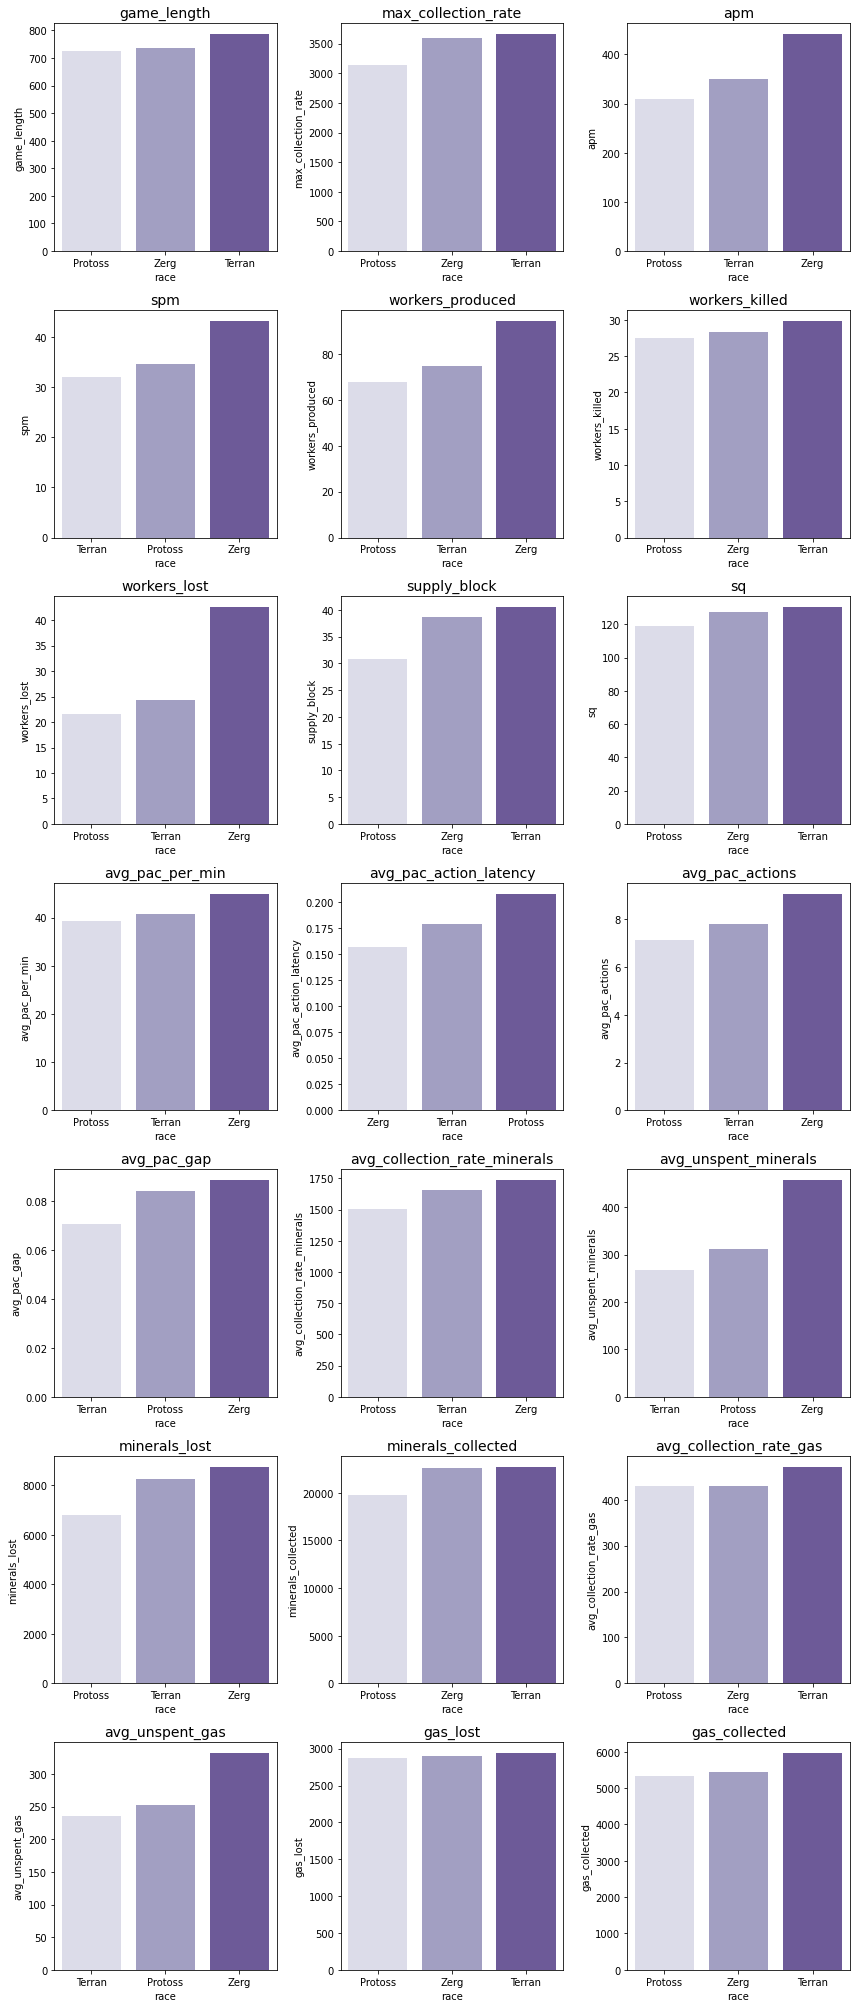

In [9]:
col_num = [i for i in df_new_group.columns if i != 'winner']

plt.figure(figsize=(12, 28))
for i in range(0, len(col_num)):
    plt.subplot(7, 3, i+1)
    sns.barplot(x=df_new_group.index, y=col_num[i], data=df_new_group , palette='Purples',
               order=df_new_group.sort_values(col_num[i]).index)
    plt.title(col_num[i], size=14)
    plt.tight_layout()

From this plot we can see traits for each race, but it's still too difficult to understand and get the conclusion. Well, I've summarize for you:

In [10]:
terran = ['Longest game length','highest max_collection_rate','lowest spm','Highest workers_killed',
          'Highest supply block','Highest sq','Lowest avg_pac_gap','Lowest avg_unspent_minerals',
          'Highest minerals_collected','Highest avg_collection_rate_gas','Lowest unspent gas',
          'Highest gas_lost','Highest gas_collected','','','','']
zerg = ['Highest apm','Highest spm','Highest workers_produced','Highest workers_lost','Highest pac_per_min',
        'Lowest avg_pac_action_latency','Highest avg_pac_actions','Highest avg_pac_gap',
        'Highest avg_collection_rate minerals','Highest avg_unspent_minerals','Highest mineral_lost',
        'Highest avg_unspent_gas','','','','','']
protoss = ['Shortest game_length','Lowest max_collection_rate','lowest apm','Lowest workers_produced',
           'Lowest workers_killed','Lowest workers_lost','Lowest supply_block','Lowest sq',
           'Lowest avg_pac_per_min','Highest avg_pac_action_latency','Lowest avg_pac_actions',
           'Lowest avg_collection_rate_minerals','Lowest mineral_lost','Lowest mineral_collected',
           'lowest avg_collection_rate_gas','lowest_gas_lost','lowest_gas_collected']

print(f"{'TERRAN':<40}{'ZERG':<40}{'PROTOSS':}")
print('-'*110)

for i in range(17):
    print(f"{terran[i]:<40}{zerg[i]:<40}{protoss[i]}")

TERRAN                                  ZERG                                    PROTOSS
--------------------------------------------------------------------------------------------------------------
Longest game length                     Highest apm                             Shortest game_length
highest max_collection_rate             Highest spm                             Lowest max_collection_rate
lowest spm                              Highest workers_produced                lowest apm
Highest workers_killed                  Highest workers_lost                    Lowest workers_produced
Highest supply block                    Highest pac_per_min                     Lowest workers_killed
Highest sq                              Lowest avg_pac_action_latency           Lowest workers_lost
Lowest avg_pac_gap                      Highest avg_pac_actions                 Lowest supply_block
Lowest avg_unspent_minerals             Highest avg_pac_gap                     Lowest sq
Highes

From here, I count each race's score to determine which race is the best. In every aspect (except game lenth), I give 3 point for race who best at that aspect and 1 for race who worst at that aspect. Based on calculation, the best race is Zerg with 42 points, and followed by Terran and Protoss who have same points (39 points). But, since Protoss most win in the aspect of unspent resources, while Terran most win in the skills, I assume that Terran have better performance than Protoss

Then, based on our findings, is that true? Let's find out who is the winner in each matchup!

### In order of matchup, which race most likely to win?

In [11]:
# add winner_char column and fill with the char name winner
for lab, row in df.iterrows():
    if row['winner'] == 1:
        df.loc[lab, 'winner_char'] = row['p1_race']
    else:
        df.loc[lab, 'winner_char'] = row['p2_race']

In [12]:
matchup_diff = df.copy()
matchup_diff.drop(matchup_diff[matchup_diff['matchup'] == 'TvT'].index, inplace=True)
matchup_diff.drop(matchup_diff[matchup_diff['matchup'] == 'PvP'].index, inplace=True)
matchup_diff.drop(matchup_diff[matchup_diff['matchup'] == 'ZvZ'].index, inplace=True)

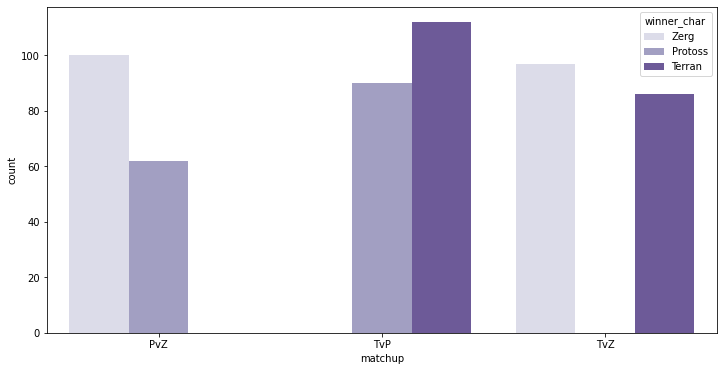

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x='matchup', hue='winner_char', data=matchup_diff, palette='Purples')
plt.show()

From the plot we can see that Zerg most likely to win when versus with Protoss, Teran most likely to win when versus Protoss, and Zerg most likely to win when versus Terran. This is accurate with our findings earlier, that Protoss < Terran < Zerg.

Alright then, let's calculate the win rate of each race!

In [14]:
# make new df, to calculate the win rate
win_rate = df.groupby('p1_race').agg({'p1_race':'count'}).rename(columns={'p1_race':'p1_count'})
win_rate2 = df.groupby('p2_race').agg({'p2_race':'count'}).rename(columns={'p2_race':'p2_count'})
winner = df.groupby('winner_char').agg({'winner_char':'count'}).rename(columns={'winner_char':'win_count'})
win_rate = pd.merge(win_rate, win_rate2, left_index=True, right_index=True)
win_rate = pd.merge(win_rate, winner, left_index=True, right_index=True)
win_rate.index.names = ['char']
win_rate['total_match'] = win_rate['p1_count']+win_rate['p2_count']
win_rate['win_rate'] = win_rate['win_count']/win_rate['total_match']
win_rate

,p1_count,p2_count,win_count,total_match,win_rate
char,,,,,
Protoss,325,323,294,648,0.453704
Terran,269,264,272,533,0.510319
Zerg,235,242,263,477,0.551363


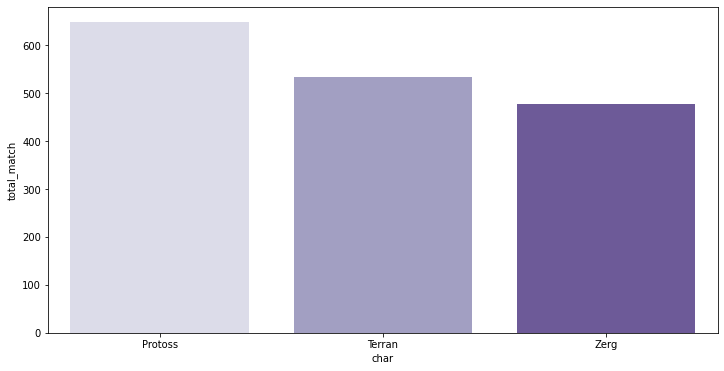

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(x=win_rate.index, y='total_match', data=win_rate, palette='Purples')
plt.show()

Wow, it is almost shocking! Although Protoss is the worst race, but Most of the player choose Protoss as their race to play. Same happens to Zerg, only few player choose Zerg as their race to play!. Eitss, it's not yet plot the win rate!!!

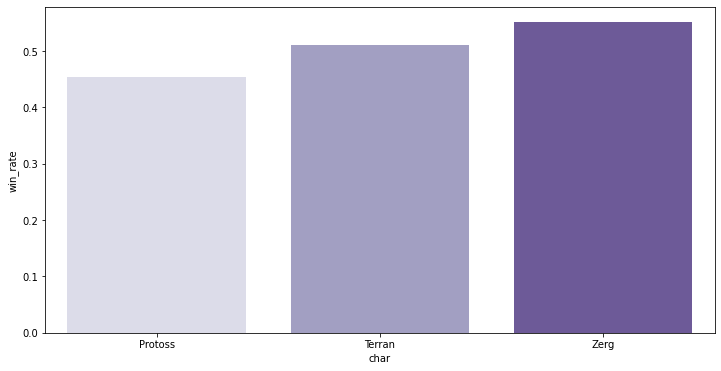

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(x=win_rate.index, y='win_rate', data=win_rate, palette='Purples')
plt.show()

Since Zerg is the best performed race, it comes as no surprise that Zerg has the highest win rate (55%), then followed by Terran (51%) and Protoss (45%)

## The Matchup

From 829 played games, actually which matchup is the most favourite matchup to play?

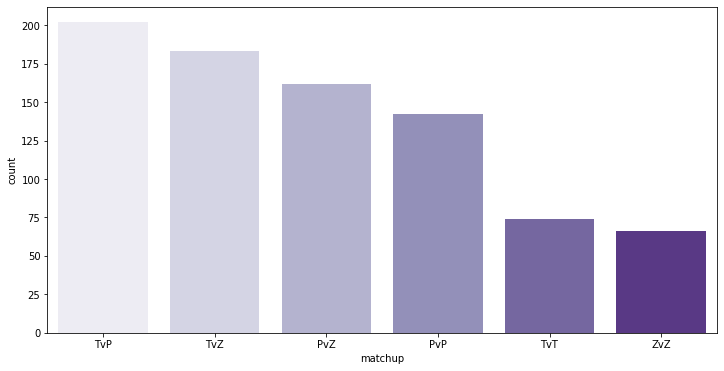

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='matchup', data=df, 
              order = df['matchup'].value_counts().index, palette='Purples')
plt.show()

Ooh!, it turns out that the most played matchup is Terran vs Protoss. Waitt, why Protoss player are favoured to match versus Terran and Zerg, rathen than same race, even though based on our observation that Protoss most likely to lose when match versus Terran and Zerg? Hmm, maybe after Starcraft 2 players read this analysis, they can re-consider which race and matchup they wil play next game :). 

Then, is there any characteristic for each matchup? for instance, the game length, which matchup take longest time?

In [18]:
df_new = df.groupby('matchup').mean()

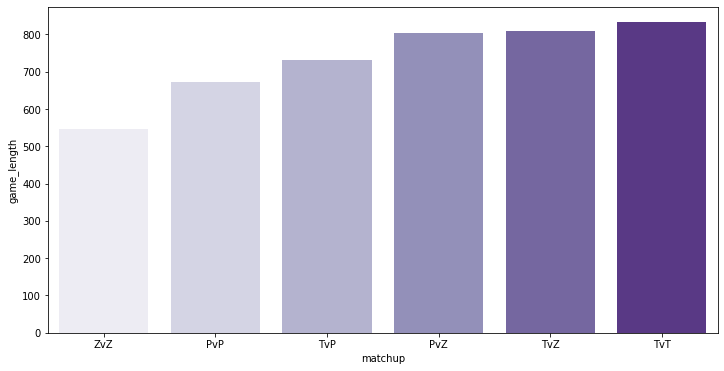

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(x=df_new.index, y='game_length', data=df_new, palette='Purples',
           order=df_new.sort_values('game_length').index)
plt.show()

So, TvT take longest time to play. I assume that match versus with same race will take longer time because they have same performance and ability. So it will take longer time to finish the game. But, I still wonder why ZvZ end very soon compared to others? Although based on my assumptions it should take longer time than match with different race

How about the resources? Are each matchup has characteristic according to resources?

In [20]:
# caclcualte the average of max collection rate, collection rate of gas and minerals
df_new['max_collection_rate'] = (df_new['p1_max_collection_rate'] + df_new['p2_max_collection_rate'])/2
df_new['minerals'] = (df_new['p1_avg_collection_rate_minerals']+df_new['p2_avg_collection_rate_minerals'])/2
df_new['gas'] = (df_new['p1_avg_collection_rate_gas']+df_new['p2_avg_collection_rate_gas'])/2
to_choose = ['max_collection_rate','minerals','gas']
df_newest = df_new[to_choose]

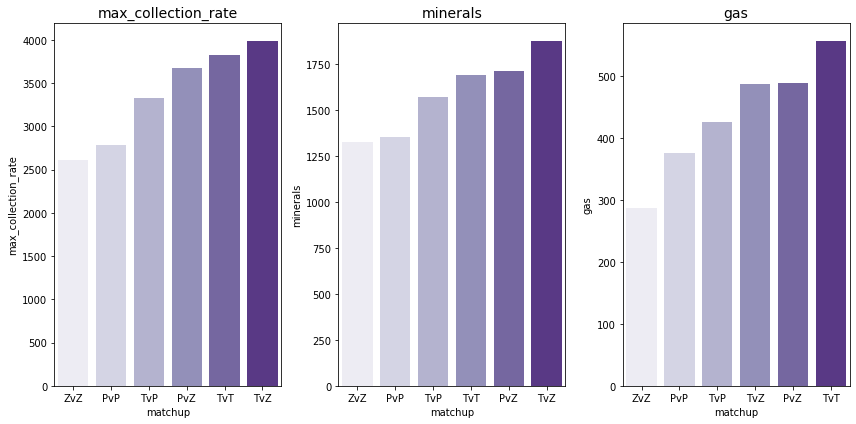

In [21]:
col_name = [i for i in df_newest.columns]
plt.figure(figsize=(12, 6))
for i in range(0, len(col_name)):
    plt.subplot(1, 3, i+1)
    sns.barplot(y=col_name[i], x=df_newest.index, data=df_newest,
               order=df_new.sort_values(col_name[i]).index, palette='Purples')
    plt.title(col_name[i], size=14)
    plt.tight_layout()

Of course! As long we have the data, we can calculate and find the insights.

In order of  average max collection rate, apparently TvZ has the highest average of player1 and player2. Then, in order of minerals, TvZ has the highest average of mineral collection rate, and TvT has the highest average gas collection rate. Apparently, ZvZ has the lowest average in every average resource collection rate. I assume it can be happen beacuse ZvZ only take short period of time of the game, resulting only collect few of the resources

## The Race and Matchup

Is there any connections between race and matchup? Yes of course! Terran race will never matchup to ZvZ, PvPand PvZ. But, are each race favor for certain matchup? Let's found out!

In [22]:
p1_only = df[['matchup', 'p1_race']]
p1_only = p1_only.rename(columns={'p1_race':'race'})

p2_only = df[['matchup', 'p2_race']]
p2_only = p2_only.rename(columns={'p2_race':'race'})

race_matchup = pd.concat([p1_only, p2_only], axis=0)

grup = race_matchup.groupby(by=['race', 'matchup']).agg({'matchup':'count'})
grup = grup.rename(columns={'matchup':'count'})
grup = grup.sort_values('count')

In [23]:
protoss = grup.loc['Protoss', 'count']
terran = grup.loc['Terran', 'count']
zerg = grup.loc['Zerg', 'count']

lst = [protoss, terran, zerg]
title = ['Protoss', 'Terran', 'Zerg']
explode = (0, 0, 0.1)

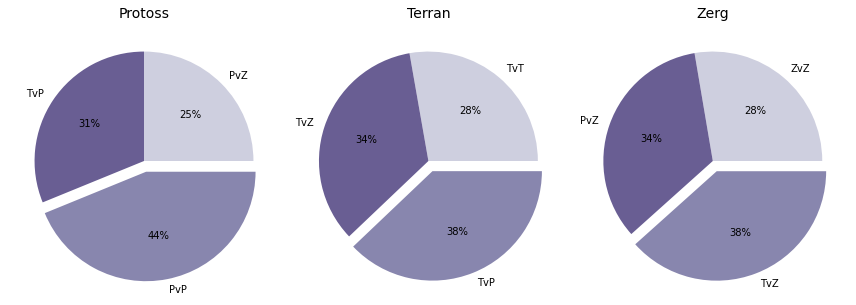

In [24]:
colors = ['#CECFDF', '#695E93', '#8886AE']

plt.figure(figsize=(12, 6))
for i in range(0, len(lst)):
    plt.subplot(1, 3, i+1)
    plt.pie(lst[i].unique(), autopct='%.0f%%', labels=lst[i].index, explode=explode, colors=colors)
    plt.title(title[i], size=14)
    plt.tight_layout()

Apparently, each race also favour to certain matchup. Protoss most likely having matchup with fellow Protoss. While most of Terran race choose to match versus Protoss. Lastly, Zerg are most likely to fight against Terran.

## The Correlation

Is there any correlation between one feature to another? Let's find out!

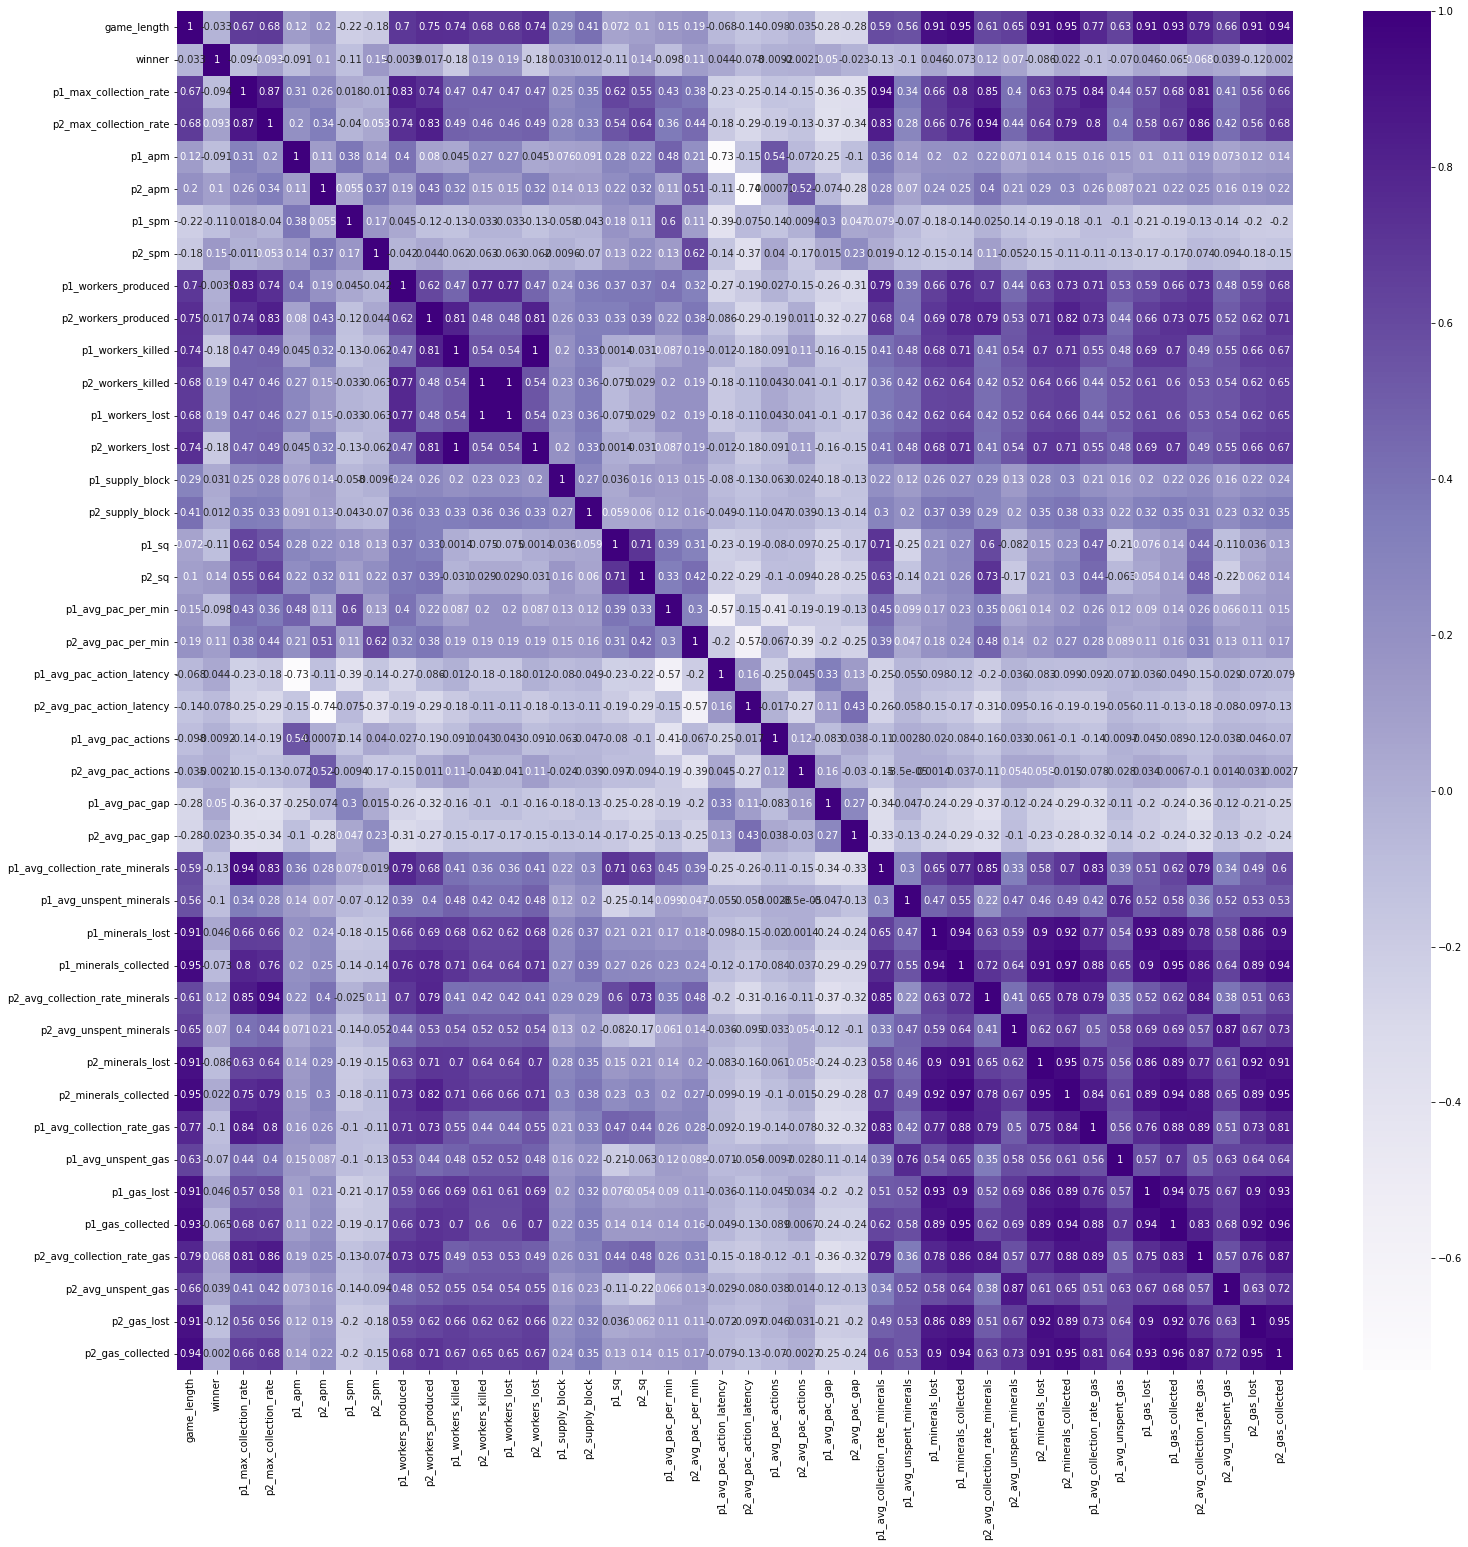

In [25]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot=True, cmap='Purples')
plt.show()

The darkest the square, it means they are highly correlated (approaching 1). Then, we can see that p1_workers_killed & p2_workers_lost and p1_workers_lost & p2_workers_killed are highly correlated. We can drop one of them, so it's not make the code redundant!

## The Map

If we talk about game, it still incomplete if we don't explore about the map. Let's take a look the unique value of the maps.

In [26]:
df['map'].unique()

array(['2000 애트모스피어 - 래더', 'Beckett Industries LE', '[ESL] Berlingrad',
       '블랙번 - 래더', '2000 Atmospheres LE', '光影交错-天梯版', 'Blackburn LE',
       'Oxide LE', 'Blackburn EE', 'Berlingrad LE', '[ESL] Hardwire',
       'Jagannatha LE', '[ESL] Glittering Ashes', '[ESL] Blackburn',
       'Glittering Ashes LE', '[ESL] Curious Minds', 'Lightshade LE',
       '하드와이어 - 래더', '프라이드 오브 알타리스 - 래더', 'Hardwire LE', '베를린그라드 - 래더',
       '[TLMC15] Glittering Ashes', '글리터링 애쉬즈 - 래더',
       '[TLMC15] Pride of Altaris', '[TLMC15] Hardwire', 'Romanticide LE',
       '大气2000-天梯版', 'Curious Minds LE', '큐리어스 마인즈 - 래더',
       '[TLMC15] Curious Minds', '锈化山巅-天梯版', 'Berlingrad EC',
       '[TLMC15] Berlingrad', '[TLMC14] Blackburn', 'Pride of Altaris LE',
       '硬线-天梯版', 'Mentes curiosas EE', 'Берлинград РВ',
       '2000 атмосфер РВ', '[ESL] Pride of Altaris', '柏林加德-天梯版',
       '黑色燃烧-天梯版', '世界主宰-天梯版', '紫晶浪漫-天梯版', 'Atmosphère 2\xa0000 EC',
       '新奇之地-天梯版'], dtype=object)

Hmm, I can't read all the maps 😿🙀. But then, thanks to Google Translate, I translate all those foreign language into English. Surprisingly, most of them are the same map, but different version and language. Okay, I think's it will be much better if I translate into English and gather all the same maps.

In [27]:
map_change = {'2000 애트모스피어 - 래더':'2000 Atmospheres LE','大气2000-天梯版':'2000 Atmospheres LE',
              '2000 атмосфер РВ':'2000 Atmospheres LE',
             'Atmosphère 2\xa0000 EC':'2000 Atmospheres LE','[ESL] Berlingrad':'Berlingrad','[ESL] Hardwire':'Hardwire',
             '글리터링 애쉬즈 - 래더':'Glittering Ashes','블랙번 - 래더':'Blackburn','黑色燃烧-天梯版':'Blackburn',
              '베를린그라드 - 래더':'Berlingrad','Oxide LE':'Oxide','Jagannatha LE':'Jagannatha','光影交错-天梯版':'Lightshade',
             'Lightshade LE':'Lightshade','하드와이어 - 래더':'Hardwire','Hardwire LE':'Hardwire',
              '[TLMC15] Glittering Ashes':'Glittering Ashes','[TLMC15] Pride of Altaris':'Pride of Altaris',
             '硬线-天梯版':'[TLMC15] Hardwire','[TLMC15] Hardwire':'Hardwire','紫晶浪漫-天梯版':'Romanticide',
              'Romanticide LE':'Romanticide','큐리어스 마인즈 - 래더':'Curious Minds','Curious Minds LE':'Curious Minds',
             '[TLMC15] Curious Minds':'Curious Minds','Берлинград РВ':'Berlingrad','Berlingrad EC':'Berlingrad',
             '[TLMC15] Berlingrad':'Berlingrad','[TLMC14] Blackburn':'Blackburn','프라이드 오브 알타리스 - 래더':'Pride of Altaris',
             'Pride of Altaris LE':'Pride of Altaris','[ESL] Pride of Altaris':'Pride of Altaris',
             '[ESL] Glittering Ashes':'Glittering Ashes','[ESL] Blackburn':'Blackburn','Blackburn LE':'Blackburn',
             'Blackburn EE':'Blackburn','Berlingrad LE':'Berlingrad','Glittering Ashes LE':'Glittering Ashes',
             '[ESL] Curious Minds':'Curious Minds','锈化山巅-天梯版':'Oxide','柏林加德-天梯版':'Berlingrad',
             '世界主宰-天梯版':'World Domination','新奇之地-天梯版':'Novelty'}
df['map'].replace(map_change, inplace=True)

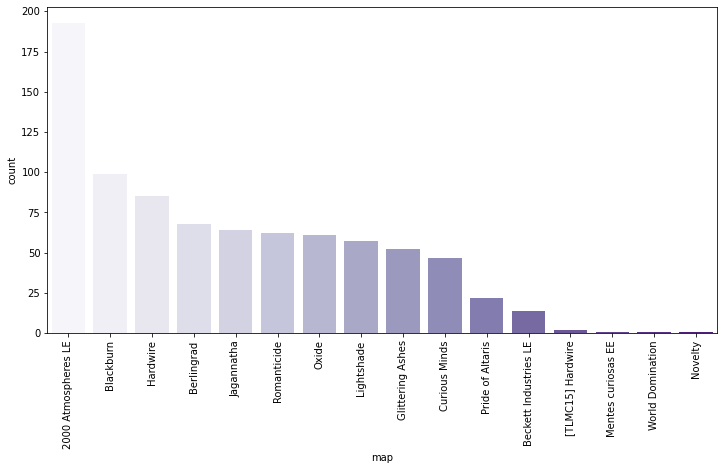

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(x='map', data=df, order = df['map'].value_counts().index, palette='Purples')
plt.xticks(rotation=90)
plt.show()

Wow, 2000 Atmospheres LE played the most with siginifant difference to the second position!

I still wonder, since Zerg win the most, which map is the most used by Zerg when the outcome is Zerg as a winner?

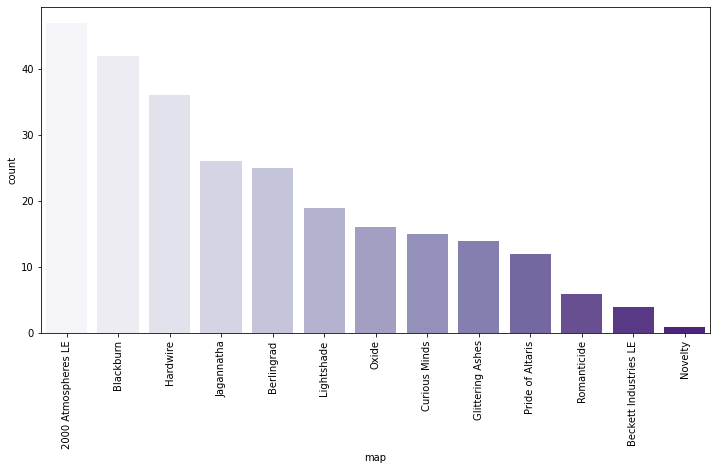

In [29]:
win_zerg_only = df[df['winner_char'] == 'Zerg']

plt.figure(figsize=(12,6))
sns.countplot(x='map', data=win_zerg_only, order = win_zerg_only['map'].value_counts().index, palette='Purples')
plt.xticks(rotation=90)
plt.show()

Oh, it's not has lot of different with overall maps. Most of Zerg winner play at 2000 Atmospheres LE

# Machine Learning Model

In [30]:
# import libraries
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder

In [31]:
# Load the train dataset
train = pd.read_csv('../input/ristek-2022-oprec/train.csv')
train.head()

,id,played_at,tournament,map,game_length,winner,matchup,p1_max_collection_rate,p2_max_collection_rate,p1_apm,...,p1_avg_collection_rate_gas,p1_avg_unspent_gas,p1_gas_lost,p1_gas_collected,p2_avg_collection_rate_gas,p2_avg_unspent_gas,p2_gas_lost,p2_gas_collected,p1_race,p2_race
0,0205bd314da54b6fb363a998ca0c49ba,2022-02-25 03:01:50+00:00,IEM Katowice,2000 애트모스피어 - 래더,848,2,TvT,3778,3952,316,...,533.8,273.8,3436,6384,636.3,253.2,2864,7412,Terran,Terran
1,7ca6c874c8064364b4247780495fe4f2,2021-10-17 05:11:18+00:00,DH Masters Winter,Beckett Industries LE,612,1,PvZ,4344,3140,398,...,473.9,236.7,625,4265,427.4,201.3,850,3665,Zerg,Protoss
2,92ccfb1330424a4fb572585b8d6ea4c9,2021-10-10 01:50:23+00:00,DH Masters Winter,Beckett Industries LE,486,2,PvZ,3095,2944,389,...,226.5,157.6,800,1668,336.1,170.0,75,2436,Zerg,Protoss
3,d592c15de2a94b6aa5278b0fc241de54,2022-02-25 04:27:49+00:00,IEM Katowice,[ESL] Berlingrad,1078,2,PvZ,4064,4193,449,...,749.7,401.2,5850,11682,892.6,664.5,3850,13344,Protoss,Zerg
4,6a24b0487aef460a982d2ec930947c11,2021-12-15 19:17:24+00:00,DH Masters Last Chance,블랙번 - 래더,1001,1,PvZ,4484,4243,627,...,826.1,299.8,8975,11930,675.6,174.5,8200,10256,Zerg,Protoss


## Model with Raw Data & Default Parameter

Before doing some manipulations, why don't we try to make model with raw data, and default parameter. So, we can see the differences after we manipulate the dataset and try to change some parameter

Machine Learning model can't be used in categorical variables, so we need to make little bit encoding to convert categorical data into numerical. In this dataset, we use One Hot Encoding.

In [32]:
# One Hot Encode
def OneHotEncode(df):
    df = df.copy()
    category = df.select_dtypes(include=object).columns.to_list()
    category.remove('matchup')
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[category]))
    OH_cols.index = df.index
    num = df.drop(category, axis=1)
    OH = pd.concat([num, OH_cols], axis=1)
    return OH

In [33]:
# drop unused columns
to_drop = ['p1_race', 'p2_race', 'id']
train_no_fe = train.drop(columns=to_drop)

# One Hot Encode the df
train_no_fe = OneHotEncode(train_no_fe)

# Split data
X = train_no_fe.drop('matchup', axis = 1)
y = train_no_fe['matchup']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Model
model = CatBoostClassifier(silent=True)
model.fit(X_train, y_train)

print('Training Accuracy :', model.score(X_train, y_train))
print('Testing Accuracy :', model.score(X_test, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.6566265060240963


Alright, the model with raw data and using the default parameter resulting in about 65% accuracy.

## Feature Selection and Engineering

The machine learning model need to have Feature Selection and Feature Engineering proccess to get more precise predictions, Let's do some!

#### Feature Engineering

In this section, we try to do some manipulation on the data.

We know that the dataset contain played_at columns, but it still too raw if we select that feature into our model. Here, I want to add time and date columns. Let's see what happen to the model's accuracy

In [34]:
# add time and date column
train['time'] = train['played_at'].apply(lambda x: int(x.split()[1][:2]))
train['date'] = pd.to_datetime(train['played_at']).dt.date

Also remember, earlier we have found that each race has it's APM's characteristic, and it's pretty consistent. APM for Zerg is more likely higher than Terran, and followed by Protoss as the race with the least APM among others.

In the dataset, the order of P1 and P2 are random. What if, we try to re-order of P1 and P2 based on their APM. So, the P2 is the race with the higher APM. Maybe it has a good impact to our model's accuracy.

In [35]:
cols = train.columns

# Function to swap player, if P1 has higher APM than P2
def swap_player(row):
    if row["p1_apm"] > row["p2_apm"]:
        
        for col in cols:
            if "p1" in col:
                row[col], row[col.replace("p1", "p2")] =  row[col.replace("p1", "p2")], row[col]
            elif col == 'winner':
                if row[col] == 1:
                    row[col] = 2
                elif row[col] == 2:
                    row[col] = 1
    return row

train_new = train.apply(swap_player, axis=1)

#### Feature Selection

In this part, we try to only select the right columns, so the model is more precise

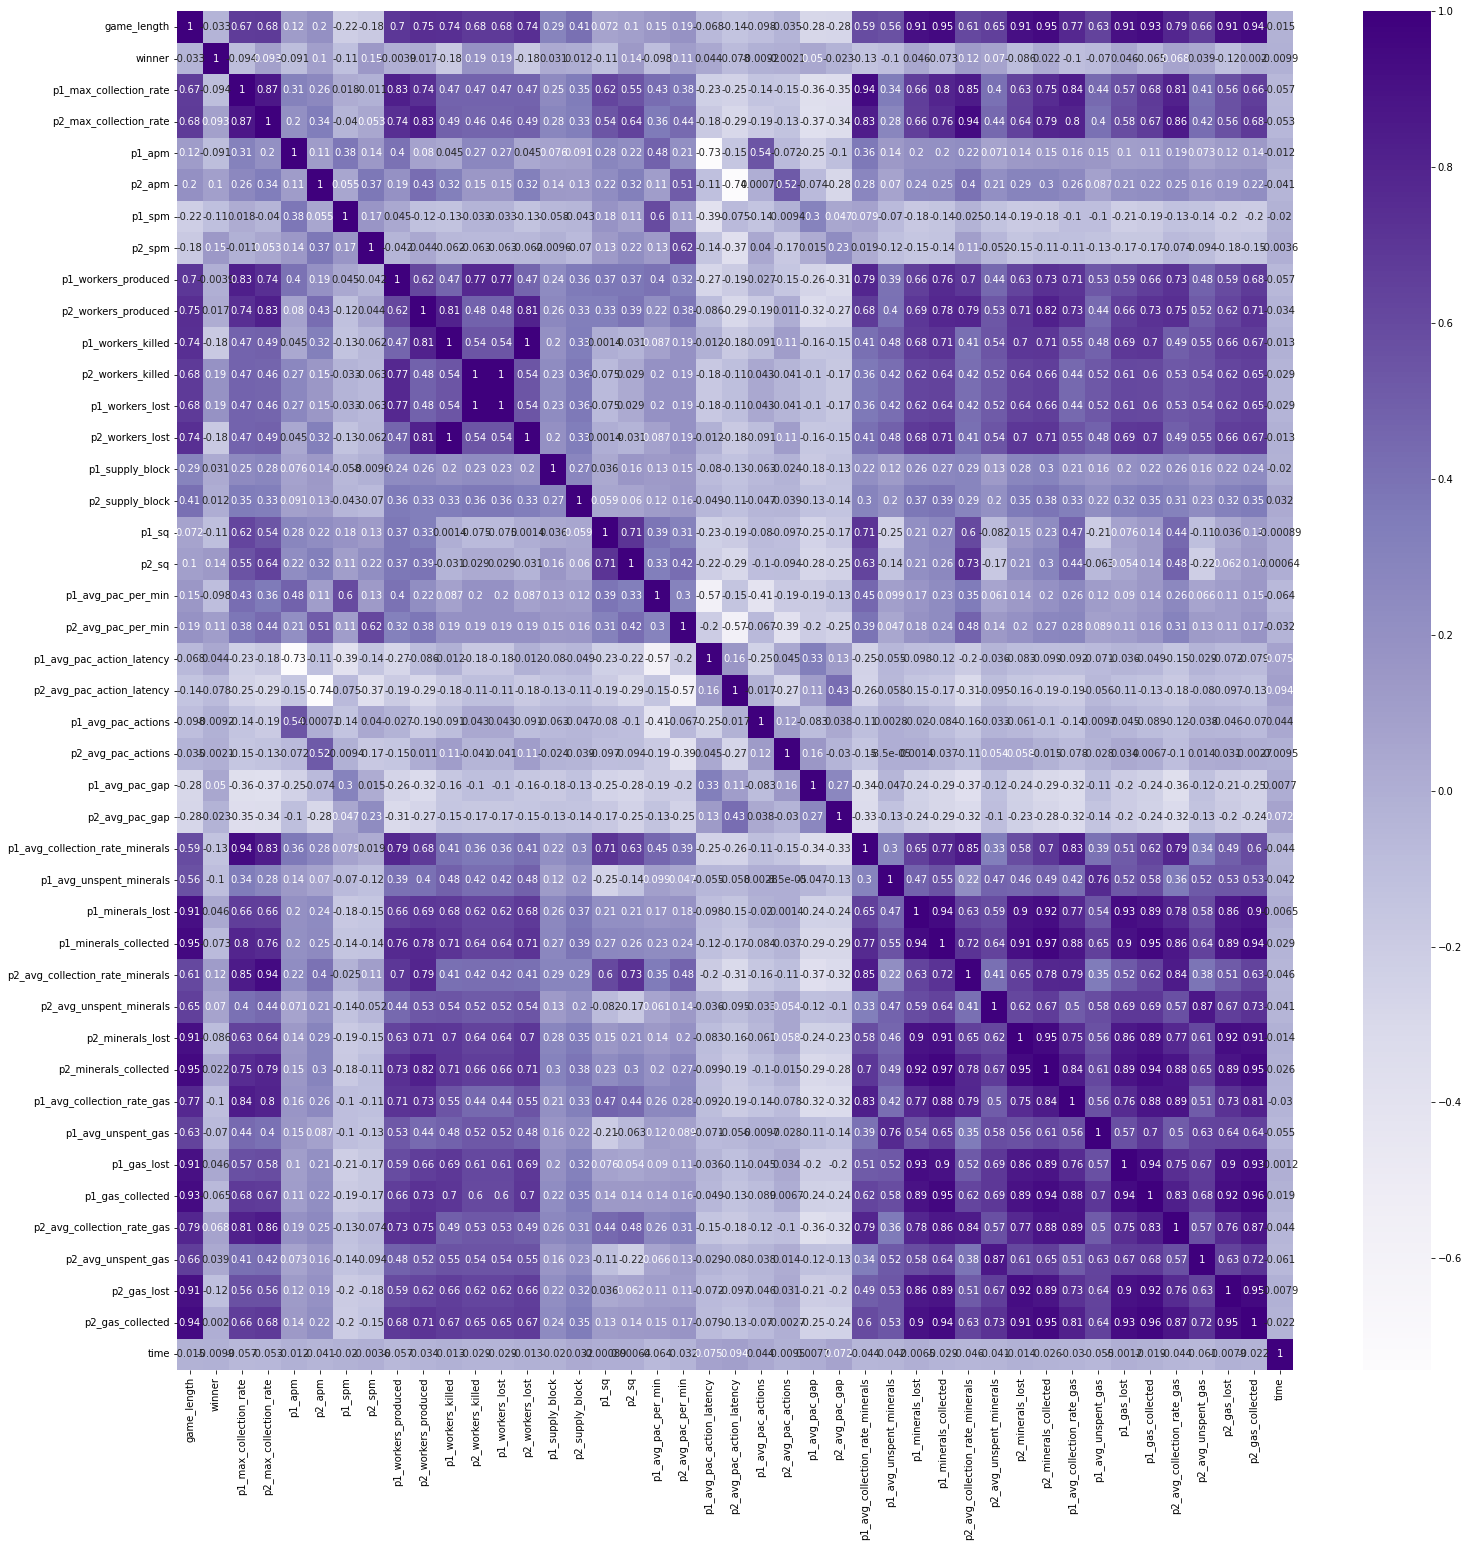

In [36]:
plt.figure(figsize=(25,25))
sns.heatmap(train.corr(), annot=True, cmap='Purples')
plt.show()

The darkest the square, it means they are highly correlated (approaching 1). Then, we can see that p1_workers_killed & p2_workers_lost and p1_workers_lost & p2_workers_killed are highly correlated. We can drop one of them, so it's not make the code redundant!

Also, if you notice, the area of right bottom corner are seems look darker than any other areas. Based on my observations, those darker areas are columns for resources, and if we look closer some columns are related to each other. Here I try to drop some columns; p1_minerals_collected, p2_minerals_collected, p1_gas_collected, and p2_gas_collected.

In [37]:
to_drop = ['p1_race', 'p2_race', 'id', 'p1_workers_killed', 'p2_workers_killed', 'p1_minerals_collected', 'p2_minerals_collected', 'p1_gas_collected', 
          'p2_gas_collected', 'played_at']
train_new = train_new.drop(columns=to_drop)

In [38]:
# One Hot Encode
train_new = OneHotEncode(train_new)

# Split data
X = train_new.drop('matchup', axis = 1)
y = train_new['matchup']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Model
model = CatBoostClassifier(silent=True)
model.fit(X_train, y_train)

print('Training Accuracy :', model.score(X_train, y_train))
print('Testing Accuracy :', model.score(X_test, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.7831325301204819


Wow, the model's accuracy seems to increase pretty high after we do some Feature Engineering and Feature Selection

## Model with Some Hyperparameter Tuning

The previous model are pretty accurate, but why don'w we try to custom some of the parameter? After some of iterations and attempts, based on my observations that these combinations of parameters resulting in a best model's accuracy; n_estimators=1000, learning_rate=0.35, max_depth=6. Let's try and look how it affect the model

In [39]:
model = CatBoostClassifier(silent=True, n_estimators=1000, learning_rate=0.35, max_depth=6) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Training Accuracy :', model.score(X_train, y_train))
print('Testing Accuracy :', model.score(X_test, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.8012048192771084


Woww, although the improvement isn't too high from the previous model, but it's still nice to see that the model's accuracy is improving. I guess, we will use this model as our final model for this dataset.

## Conclusion

-  Based on characteristic, Zerg is the most powerful race, followed by Terran then Protoss.
- It is also concluded that Zerg is most likely win when versus with Terran or Protoss. Terran also most likely to win when match with Protoss.
- Apart from our observations, the most favorite race of the players are Protoss, followed by Terran and Zerg.
- TvP is the most played matchup, while ZvZ is the least played matchup.
- In order of the game length, TvT takes longest time to played and ZvZ only played in a short duration of time.
- TvZ matchup, has the highest max resource collection rate and minerals collection rate. For the gas collection rate, TvT is the highest. ZvZ matchup has the lowest collection rate in 3 of those categories.
- Protoss are more likely to matchup with Protoss, while Terran more likely to match with Protoss. And Zerg more likely to fight against Terran.
- There are highly correlated data between p1_workers_killed & p2_workers_lost and p1_workers_lost & p2_workers_killed
- The most played map is 2000 Atmospheres LE
- Since each race has it's own characteristic, especially apm, then the apm of each player has the important role in determining the matchup for each match
- The models that we are making are improving from when we use the raw data and default parameter until data after feature engineering and feature selection, also by making adjustment in the parameter



## Advice

- To get higher win rate, try to use with Zerg race against Terran/ Protoss, and choose 2000 Atmospheres LE for the map.
